## Build the Use Case
We will follow the Tensorflow Tutorial from here

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

### Get the data

In [3]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


# importing required libraries
import numpy as np
import pandas as pd
import pickle # saving and loading trained model
from os import path


# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import (StandardScaler, OrdinalEncoder,LabelEncoder, MinMaxScaler, OneHotEncoder)
from sklearn.preprocessing import Normalizer, MaxAbsScaler , RobustScaler, PowerTransformer

# importing library for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score # for calculating accuracy of model
from sklearn.model_selection import train_test_split # for splitting the dataset for training and testing
from sklearn.metrics import classification_report # for generating a classification report of model

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from keras.layers import Dense # importing dense layer

from keras.layers import Input
from keras.models import Model
# representation of model layers
# from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix
import shap


# In[2]:


/home/oarreche@ads.iu.edu/anaconda3/envs/HITL/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:


#Defining metric functions
def ACC(TP,TN,FP,FN):
    Acc = (TP+TN)/(TP+FP+FN+TN)
    return Acc
def ACC_2 (TP, FN):
    ac = (TP/(TP+FN))
    return ac
def PRECISION(TP,FP):
    eps = 1e-7
    Precision = TP/(TP+FP+eps)
    

    return Precision
def RECALL(TP,FN):
    Recall = TP/(TP+FN)
    return Recall
def F1(Recall, Precision):
    F1 = 2 * Recall * Precision / (Recall + Precision)
    return F1
def BACC(TP,TN,FP,FN):
    BACC =(TP/(TP+FN)+ TN/(TN+FP))*0.5
    return BACC
def MCC(TP,TN,FP,FN):
    eps = 1e-7
    MCC = (TN*TP-FN*FP)/(((TP+FP+eps)*(TP+FN+eps)*(TN+FP+eps)*(TN+FN+eps))**.5)
    return MCC
def AUC_ROC(y_test_bin,y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    auc_avg = 0
    counting = 0
    for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
     # plt.plot(fpr[i], tpr[i], color='darkorange', lw=2)
      #print('AUC for Class {}: {}'.format(i+1, auc(fpr[i], tpr[i])))
      auc_avg += auc(fpr[i], tpr[i])
      counting = i+1
    return auc_avg/counting


# attach the column names to the dataset
feature=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
          "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells",
          "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
          "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count", 
          "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
          "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]

# KDDTrain+_2.csv & KDDTest+_2.csv are the datafiles without the last column about the difficulty score
# these have already been removed.

train='KDDTrain+.txt'
test='KDDTest+.txt'

df=pd.read_csv(train,names=feature)
df_test=pd.read_csv(test,names=feature)

# shape, this gives the dimensions of the dataset
print('Dimensions of the Training set:',df.shape)
print('Dimensions of the Test set:',df_test.shape)


df.drop(['difficulty'],axis=1,inplace=True)
df_test.drop(['difficulty'],axis=1,inplace=True)


print('Label distribution Training set:')
print(df['label'].value_counts())
print()
print('Label distribution Test set:')
print(df_test['label'].value_counts())


# colums that are categorical and not binary yet: protocol_type (column 2), service (column 3), flag (column 4).
# explore categorical features
print('Training set:')
for col_name in df.columns:
    if df[col_name].dtypes == 'object' :
        unique_cat = len(df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

#see how distributed the feature service is, it is evenly distributed and therefore we need to make dummies for all.
print()
print('Distribution of categories in service:')
print(df['service'].value_counts().sort_values(ascending=False).head())

# Test set
print('Test set:')
for col_name in df_test.columns:
    if df_test[col_name].dtypes == 'object' :
        unique_cat = len(df_test[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))


from sklearn.preprocessing import LabelEncoder,OneHotEncoder
categorical_columns=['protocol_type', 'service', 'flag']
# insert code to get a list of categorical columns into a variable, categorical_columns
categorical_columns=['protocol_type', 'service', 'flag'] 
 # Get the categorical values into a 2D numpy array
df_categorical_values = df[categorical_columns]
testdf_categorical_values = df_test[categorical_columns]
df_categorical_values.head()


# protocol type
unique_protocol=sorted(df.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
# service
unique_service=sorted(df.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
# flag
unique_flag=sorted(df.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
# put together
dumcols=unique_protocol2 + unique_service2 + unique_flag2
print(dumcols)

#do same for test set
unique_service_test=sorted(df_test.service.unique())
unique_service2_test=[string2 + x for x in unique_service_test]
testdumcols=unique_protocol2 + unique_service2_test + unique_flag2


df_categorical_values_enc=df_categorical_values.apply(LabelEncoder().fit_transform)
print(df_categorical_values_enc.head())
# test set
testdf_categorical_values_enc=testdf_categorical_values.apply(LabelEncoder().fit_transform)



enc = OneHotEncoder()
df_categorical_values_encenc = enc.fit_transform(df_categorical_values_enc)
df_cat_data = pd.DataFrame(df_categorical_values_encenc.toarray(),columns=dumcols)
# test set
testdf_categorical_values_encenc = enc.fit_transform(testdf_categorical_values_enc)
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encenc.toarray(),columns=testdumcols)

df_cat_data.head()


trainservice=df['service'].tolist()
testservice= df_test['service'].tolist()
difference=list(set(trainservice) - set(testservice))
string = 'service_'
difference=[string + x for x in difference]
difference


for col in difference:
    testdf_cat_data[col] = 0

testdf_cat_data.shape



newdf=df.join(df_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)
# test data
newdf_test=df_test.join(testdf_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)
print(newdf.shape)
print(newdf_test.shape)

# take label column
labeldf=newdf['label']
labeldf_test=newdf_test['label']
# change the label column
newlabeldf=labeldf.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
newlabeldf_test=labeldf_test.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
# put the new label column back
newdf['label'] = newlabeldf
newdf_test['label'] = newlabeldf_test
print(newdf['label'].head())

# creating a dataframe with multi-class labels (Dos,Probe,R2L,U2R,normal)
multi_data = newdf.copy()
multi_label = pd.DataFrame(multi_data.label)

multi_data_test=newdf_test.copy()
multi_label_test = pd.DataFrame(multi_data_test.label)

# using standard scaler for normalizing
std_scaler = StandardScaler()
def standardization(df,col):
    for i in col:
        arr = df[i]
        arr = np.array(arr)
        df[i] = std_scaler.fit_transform(arr.reshape(len(arr),1))
    return df

numeric_col = multi_data.select_dtypes(include='number').columns
data = standardization(multi_data,numeric_col)
numeric_col_test = multi_data_test.select_dtypes(include='number').columns
data_test = standardization(multi_data_test,numeric_col_test)

# label encoding (0,1,2,3,4) multi-class labels (Dos,normal,Probe,R2L,U2R)
le2 = preprocessing.LabelEncoder()
le2_test = preprocessing.LabelEncoder()
enc_label = multi_label.apply(le2.fit_transform)
enc_label_test = multi_label_test.apply(le2_test.fit_transform)
multi_data = multi_data.copy()
multi_data_test = multi_data_test.copy()

multi_data['intrusion'] = enc_label
multi_data_test['intrusion'] = enc_label_test

#y_mul = multi_data['intrusion']
multi_data
multi_data_test


multi_data.drop(labels= [ 'label'], axis=1, inplace=True)
multi_data
multi_data_test.drop(labels= [ 'label'], axis=1, inplace=True)
multi_data_test

y_train_multi= multi_data[['intrusion']]
X_train_multi= multi_data.drop(labels=['intrusion'], axis=1)

print('X_train has shape:',X_train_multi.shape,'\ny_train has shape:',y_train_multi.shape)

y_test_multi= multi_data_test[['intrusion']]
X_test_multi= multi_data_test.drop(labels=['intrusion'], axis=1)

print('X_test has shape:',X_test_multi.shape,'\ny_test has shape:',y_test_multi.shape)



from collections import Counter

label_counts = Counter(y_train_multi['intrusion'])
print(label_counts)



from sklearn.preprocessing import LabelBinarizer

y_train_multi = LabelBinarizer().fit_transform(y_train_multi)
y_train_multi

y_test_multi = LabelBinarizer().fit_transform(y_test_multi)
y_test_multi


Y_train=y_train_multi.copy()
X_train=X_train_multi.copy()

Y_test=y_test_multi.copy()
X_test=X_test_multi.copy()


print(Y_test)



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import time

model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))  # Input layer
model.add(Dense(64, activation='relu'))  # Hidden layer
model.add(Dense(5, activation='softmax'))  # Output layer

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# summary of model layers
model.summary()
# Convert Y_test back to its original format
y_test = np.argmax(Y_test, axis=1)

# Start the timer
start = time.time()

model.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=0)

# End the timer
end = time.time()

# Calculate the time taken and print it out
time_taken = end - start
print(f'Time taken for training: {time_taken} seconds')

# Predict classes
preds = model.predict(X_test)

# Convert Y_test back to its original format
y_test = np.argmax(Y_test, axis=1)


Dimensions of the Training set: (125973, 43)
Dimensions of the Test set: (22544, 43)
Label distribution Training set:
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64

Label distribution Test set:
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess  

Now if we use the previous normalization layer we will build a DNN model for the full dataset

In [5]:
dnn_model = model

In [6]:
%%time
train_features = X_train
train_labels = Y_train
history = model.fit(
#history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 26min 3s, sys: 5min 37s, total: 31min 41s
Wall time: 12min 41s


In [9]:

test_features = X_test
test_labels = y_test
#test_predictions = y_pred

In [13]:
vec = []
for i in range (len(test_labels)):
    for j in range(5):
        vec.append(test_labels[i])

test_labels = vec  

## Explain a Regression model (with Xplique)

We now have at our disposal a model trained for a regression task and we would like to use the Xplique library in order to have some highlights towards it. First, let's load this model and import the xplique library.

In [16]:
from xplique.attributions import (Saliency,
                             IntegratedGradients,
                             KernelShap,
                             Lime,
                             Occlusion,
                             SmoothGrad,
                             VarGrad,
                             SquareGrad,
                             GuidedBackprop,
                             DeconvNet,
                             GradientInput
)

In [17]:
inputs_tf, targets_tf = tf.cast(test_features, tf.float32), tf.cast(test_labels, tf.float32)
targets_tf = tf.expand_dims(targets_tf, axis=-1)
new_targets_tf = tf.ones((22544  ,1))

In [18]:
methods_params = [
    ("Saliency", Saliency, {}),
    ("Integrated Gradients", IntegratedGradients, {}),
    ("KernelShap", KernelShap, {}),
    ("Lime", Lime, {}),
    ("Occlusion", Occlusion, {"patch_size": 1, "patch_stride": 1}),
    ("SmoothGrad", SmoothGrad, {}),
    ("VarGrad", VarGrad, {}),
    ("SquareGrad", SquareGrad, {}),
    ("GuidedBackprop", GuidedBackprop, {}),
    ("DeconvNet", DeconvNet, {}),
    ("GradientInput", GradientInput, {})
]

In [19]:
# get the different explanations
explanations = []

for name, Cls, params in methods_params:

    explainer   = Cls(dnn_model, **params)
    explanation = explainer(inputs_tf, new_targets_tf)

    explanations.append((name, explanation))

Now we will have a look at our results

In [21]:
from xplique.plots import plot_feature_impact, plot_mean_feature_impact, summary_plot_tabular

### The mean impact for every sample

In [32]:
features_name =["protocol_type","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
          "num_compromised",
          
          "dst_host_same_srv_rate","dst_host_srv_count","dst_host_same_src_port_rate","logged_in","dst_host_serror_rate","count","srv_count","dst_host_rerror_rate"
          ] 

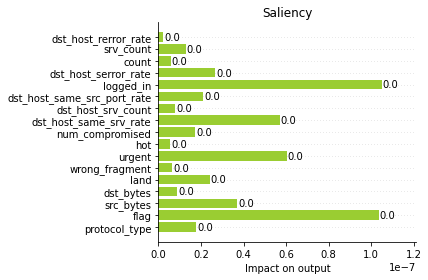

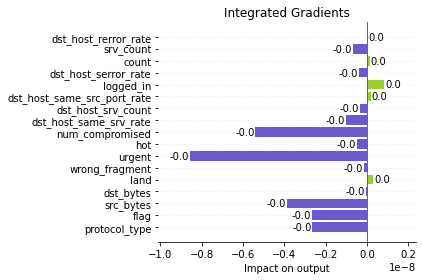

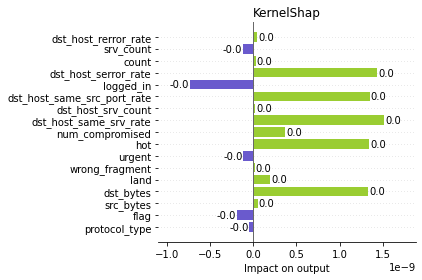

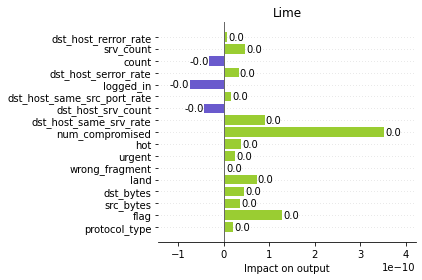

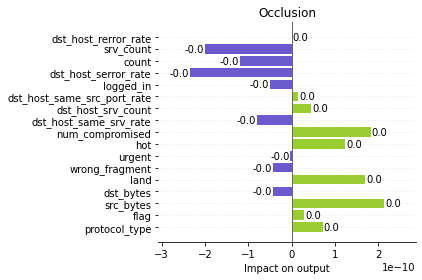

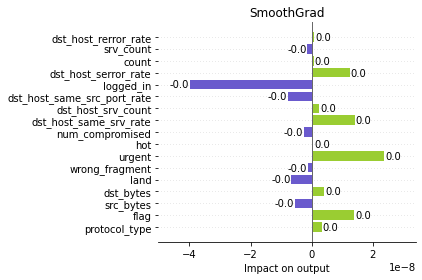

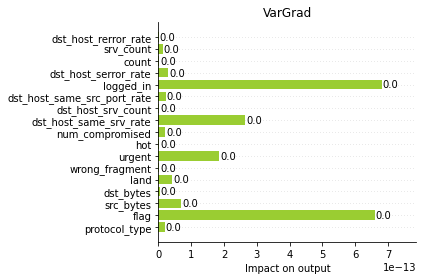

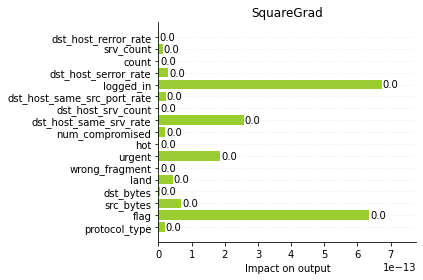

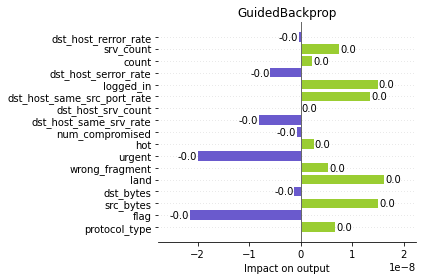

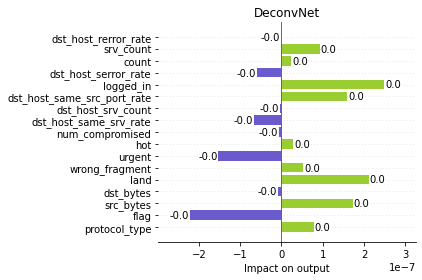

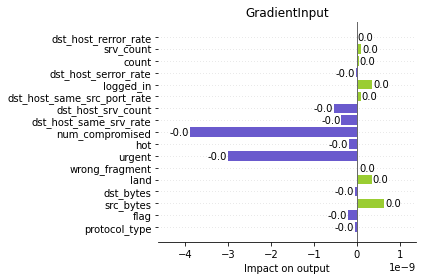

In [33]:
for exp_index, (exp_method, exp) in enumerate(explanations):
    plot_mean_feature_impact(exp, features_name)
    plt.title(exp_method)
    plt.show()